In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import calibr8
from matplotlib import pyplot
import numpy
import os
import pandas
import pathlib

import catibts

Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Create a CalibrationModel for each run
## Data Parsing
First check if folder with results exists. This path should be changed for other users accordingly.

In [3]:
fp_experiment = pathlib.Path(r"../data")
fp_experiment.exists()

True

A file named 'run_overview.xlsx' should be on the top level of the results folder.
The file contains the run_ids and the names of all result files.

In [4]:
runinfo_df = pandas.read_excel(f"{fp_experiment}/run_overview.xlsx", index_col=0)
runinfo_df

,run_id-VK,result_file-VK,run_id-HK,result_file-HK,run_id-Assay,result_file(s)-Assay,Anmerkungen
sround,,,,,,,
0,D15DTK,ReHa_CatIB_VK_2022-01-27_16-30-13.csv,D19YYZ,ReHa_CatIB_HK_2022-01-28_12-32-33.csv,D1X8DM,"2022-01-31_07-12_Fluorescence.xml, 2022-01-31_...",Hier hatte ich in der VK noch mit dem shutil-B...
1,D95YC6,ReHa_CatIB_VK_2022-03-03_19-34-37.csv,D9A1YM,ReHa_CatIB_HK_2022-03-04_14-10-23.csv,D9XCLX,"2022-03-07_09-34_Fluorescence.xml, 2022-03-08_...","Für die Vokultur gibt es mehrere Runs, die jew..."
2,DAFT9R,ReHa_CatIB_VK_2022-03-10_16-00-57.csv,DAMZ19,ReHa_CatIB_HK_2022-03-11_10-23-45.csv,DB984D,2022-03-14_05-41_Fluorescence.xml,Einige Wells der Vorkultur sind nicht richtig ...
3,DDA79K,ReHa_CatIB_VK_2022-03-24_15-26-08.csv,DDEBDB,ReHa_CatIB_HK_2022-03-25_09-54-09.csv,DE3MB4,2022-03-28_05-09_Fluorescence.xml,Ein Well zeigte schon in der VK Verhaltensauff...


Next, the paths to preculture, main culture, assay and layout file can be loaded and the calibration data parsed.

In [5]:
fp_VK, fp_HK, fp_assay, fp_layout = catibts.extract_fps_for_round(runinfo_df, fp_experiment, round_no=3)
df_calibration = catibts.read_NADH_standards(fp_layout, fp_assay)
df_calibration

,concentration,fluorescence
203,0.002046,1602.0
202,0.002046,1607.0
187,0.002046,1575.0
188,0.002046,1514.0
189,0.002046,1646.0
...,...,...
12,0.240000,16912.0
13,0.240000,16876.0
14,0.240000,16746.0
8,0.240000,16347.0


## Create a folder to save the results

In [6]:
assay_run_id = fp_assay.parts[-2]
resultpath = f'Results\{assay_run_id}' 
if not os.path.isdir(resultpath):
    os.makedirs(resultpath)

## Fit the calibration model and save it
The chosen model is normal distribution. The trend parameter mu is described by an exponential model
with a fixed intercept of 0, the scale follows a first-order polynomial.

Fit of NADHFluorescenceModel has failed:
      fun: nan
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.96533691e-02,  2.18488541e-02,  7.30293100e+01, -2.69528541e-01,
        1.31236261e+03])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 96
      nit: 5
     njev: 16
   status: 2
  success: False
        x: array([2.00581679e+02, 2.40000093e+04, 4.89757503e+00, 4.16879037e+02,
       3.24750862e-02])


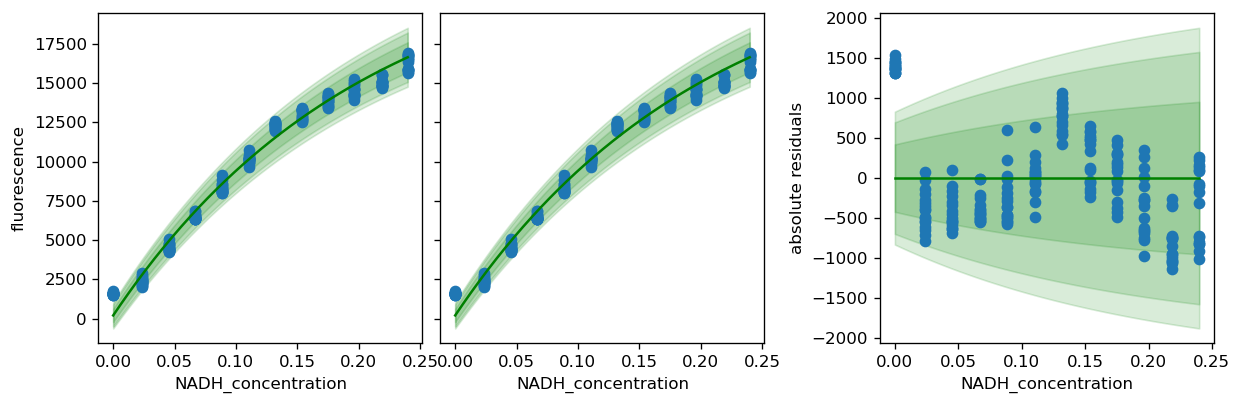

In [7]:
independent = df_calibration.concentration.values
independent[independent<0.005]=0
dependent = df_calibration.fluorescence.values
cm_nadh = catibts.NADHFluorescenceModel()
theta_fit, _ = calibr8.fit_scipy(
    model=cm_nadh,
    independent=independent,
    dependent=dependent,
    theta_guess=[200, 24000, 0.1, 400, 0.001],
    theta_bounds=[
        (-numpy.inf, 500),
        (17000, 30000),
        (0, 100),
        (2, 800),
        (-numpy.inf, 0.1)
    ]
)
cm_nadh.save(fr"{resultpath}\{assay_run_id}_cm_nadh.json")

fig, axs = calibr8.plot_model(cm_nadh)
#axs[0].set_ylim(0,2000)
pyplot.show()

In [8]:
cm_nadh.theta_fitted

(200.58167869899714,
 24000.009294074807,
 4.897575029920042,
 416.8790368785362,
 0.032475086185381814)

In [9]:
%load_ext watermark
%watermark --iversion

calibr8   : 6.5.1
catibts   : 0.1.0
matplotlib: 3.5.1
pandas    : 1.4.1
numpy     : 1.21.5

